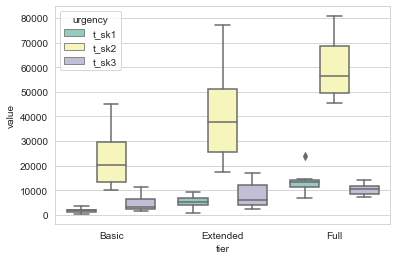

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/dgina23_hospital_sizes.csv')
d = df[['tier', 't_sk1', 't_sk2', 't_sk3']]

# reshape the d dataframe suitable for statsmodels package
d_melt = pd.melt(d, id_vars=['tier'], value_vars=['t_sk1', 't_sk2', 't_sk3'])
d_melt = d_melt.dropna(subset=['value'])
d_melt.columns = ['tier', 'urgency', 'value']

sns.boxplot(x="tier", y="value", hue="urgency", data=d_melt, palette="Set3");

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(tier) + C(urgency) + C(tier):C(urgency)', data=d_melt).fit()

# Choosing typ=3 because of unbalanced data
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,2.646074e+07,1.0,0.281503,0.597676
C(tier),5.616650e+08,2.0,2.987639,0.057956
C(urgency),2.699537e+09,2.0,14.359527,0.000008
C(tier):C(urgency),1.985568e+09,4.0,5.280869,0.001036
Residual,5.639888e+09,60.0,NaN,NaN


In [6]:
from bioinfokit.analys import stat

res = stat()
res.anova_stat(df=d_melt, res_var='value', anova_model='value~C(tier)+C(urgency)+C(tier):C(urgency)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(tier),2.0,3.653790e+09,1.826895e+09,19.435440,3.108032e-07
C(urgency),2.0,1.685671e+10,8.428353e+09,89.665114,9.432154e-19
C(tier):C(urgency),4.0,1.985568e+09,4.963919e+08,5.280869,1.035608e-03
Residual,60.0,5.639888e+09,9.399813e+07,NaN,NaN


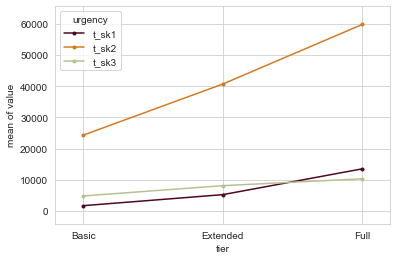

In [7]:
from statsmodels.graphics.factorplots import interaction_plot

# Generate interaction plot
fig = interaction_plot(x=d_melt['tier'], trace=d_melt['urgency'], response=d_melt['value'], colors=['#4c061d','#d17a22', '#b4c292'])

plt.show()

In [8]:
def red_font_negatives(series):
    highlight = 'font-weight: bold; color: red;'
    default = ''
    return [highlight if e <= 0.001 else default for e in series]

# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res.tukey_hsd(df=d_melt, res_var='value', xfac_var=['tier','urgency'], anova_model='value ~ C(tier) + C(urgency) + C(tier):C(urgency)')
res.tukey_summary.head()

t1 = res.tukey_summary.style \
    .format(precision=5, thousands="", decimal=",") \
    .hide(axis='index') \
    .apply(red_font_negatives, axis=0, subset=['p-value'])

t1

/Users/nplhse/opt/anaconda3/lib/python3.9/site-packages/bioinfokit/analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


group1,group2,Diff,Lower,Upper,q-value,p-value
"('Basic', 't_sk1')","('Basic', 't_sk2')","22598,11111","7893,14286","37303,07936","6,99252","0,00100"
"('Basic', 't_sk1')","('Basic', 't_sk3')","3118,77778","-11586,19047","17823,74602","0,96504","0,90000"
"('Basic', 't_sk1')","('Extended', 't_sk1')","3530,19048","-12190,08183","19250,46278","1,02180","0,90000"
"('Basic', 't_sk1')","('Extended', 't_sk2')","38967,61905","23247,34674","54687,89135","11,27897","0,00100"
"('Basic', 't_sk1')","('Extended', 't_sk3')","6412,04762","-9308,22468","22132,31992","1,85593","0,90000"
"('Basic', 't_sk1')","('Full', 't_sk1')","11804,33333","-3915,93897","27524,60564","3,41670","0,29478"
"('Basic', 't_sk1')","('Full', 't_sk2')","58059,04762","42338,77532","73779,31992","16,80489","0,00100"
"('Basic', 't_sk1')","('Full', 't_sk3')","8615,47619","-7104,79611","24335,74849","2,49370","0,68126"
"('Basic', 't_sk2')","('Basic', 't_sk3')","19479,33333","4774,36509","34184,30158","6,02748","0,00223"
"('Basic', 't_sk2')","('Extended', 't_sk1')","19067,92063","3347,64833","34788,19294","5,51911","0,00702"


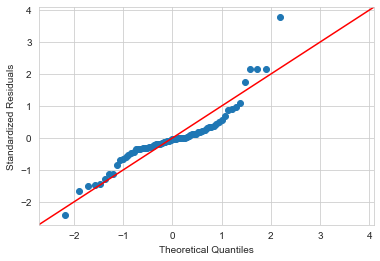

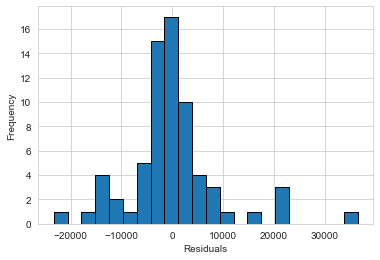

In [9]:
# Test ANOVA assumptions
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [10]:
import scipy.stats as stats

# Shapiro-Wilk to check the normal distribution of residuals
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.8933974504470825 2.4300234144902788e-05


In [11]:
# Bartlett’s test to check the Homogeneity of variances
res.bartlett(df=d_melt, res_var='value', xfac_var='urgency')
res.bartlett_summary

,Parameter,Value
0,Test statistics (T),59.2029
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


In [12]:
# Levene’s test
res = stat()
res.levene(df=d_melt, res_var='value', xfac_var='urgency')
res.levene_summary

,Parameter,Value
0,Test statistics (W),27.0774
1,Degrees of freedom (Df),2.0000
2,p value,0.0000
